# TACS Exam WS 23/24

### Organizational

The exam is carried out in 5 teams of 2 or 3 students each. The tasks are to classify images with 3 categories of objects:
1. **Yun Lin**, **Jorge Ulises Montañez Arnaus** & **Yang Yutian**: Dirt Roads vs. Country Roads vs. Highways
2. **Janet Nogossek**, **Nathalie Kurz** & **Lili Mounier**: Tennis vs. Rugby vs. Football (Soccer)
3. **Alexander Gensch**, **Lea Döttling** & **Batuhan Dursun**: Bridges vs. (Big / Office) Buildings vs. (Detached) Houses
4. **Marcel Kraft** & **Mario Kozul**: Rivers vs. Lakes vs. Seas
5. **Diego Galvan** & **Victor Chapela**: Computers vs. Smartphones vs. Tablets

The final report including the jupyter notebook must be submitted to Ilias by **Sunday, January 7th, 2024, 23:59** at the latest.

The final presentations (10 min per group) will be held on **Wednesday, January 10th, 2024, 9:50 - 13:00**.

___

Group No.: 5

Categories: Computers vs. Smartphones vs. Tablets

Student 1:
- Name: Diego Galvan Arellano
- Matriculation: 90321

Student 2:
- Name: *FILL IN*
- Matriculation: *FILL IN*

___

### Tasks

#### Data collection and preparation

Collect and prepare exactly **360 images** (online search or manuel generation):
- **300 images** for training (**100 images** per category) and
- **60 images** for testing (**20 images** per category).

Prepare the images to have:
- **224 x 224** pixels per images with **3 color channels** -> shape (300, 224, 224, 3) and (60, 224, 224, 3)
- Numpy float32 data type with range from 0.0 to 1.0

Prepare the labels to have:
- Uint8 data type with values in {0, 1, 2} -> shape (300) and (60)

Apply augmentation strategies to multiply the training data (not the test data!) using one of the following concepts
- <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers">Keras layers</a> for augmentation, e.g. <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers/RandomFlip">RandomFlip</a>
- <a href="https://www.tensorflow.org/api_docs/python/tf/keras/layers">Keras image preprocessing</a>, e.g. <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/random_zoom">random_zoom</a>
- Keras <a href="https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator">ImageDataGenerator</a>

#### Model training and evaluation

Develop, train and evaluate **four** different models (MLP, CNN Small, CNN Medium, CNN Large) with the following restrictions using <a href="https://www.tensorflow.org/api_docs/python/tf/keras/Sequential">Keras Sequential Model</a>:
<html>
    <table>
        <tr>
            <th>Maximim number of</th>
            <th>MLP</th>
            <th>CNN Small</th>
            <th>CNN Medium</th>
            <th>CNN Large</th>
        </tr>
        <tr>
            <td>Dense layers</td>
            <td>8</td>
            <td>1</td>
            <td>2</td>
            <td>2</td>
        </tr>
        <tr>
            <td>Conv2D layers</td>
            <td>0</td>
            <td>4</td>
            <td>10</td>
            <td>30</td>
        </tr>
        <tr>
            <td>trainable parameters</td>
            <td>150M</td>
            <td>10M</td>
            <td>30M</td>
            <td>100M</td>
        </tr>
    </table>
</html>
    
Compare the neural networks regarding:
- reached accuracy
- required trainings steps
- observed overfitting
    
Hints:
- Try ReLU activations first (for Conv2D and Dense layers except last layer)
- Use Flatten layers before first Dense layer
- First layer must define input_shape=(224, 224, 3)

#### Result visualization

Plot the results, e.g. accuracy over epochs graph or image and predition plots, using the <a href="https://matplotlib.org/stable/api/pyplot_summary.html">matplotlib.pyplot</a> module:

<html>
    <img src="accuracy_and_loss.png" width="280px" style="display: inline-block; vertical-align: top;"/>
    <img src="results.png" width="500px" style="display: inline-block; vertical-align: top;"/>
</html>

### Final report

Write a final report of approximatly 6 or 9 pages (3 pages per student) including plots.

The report should cover the following aspects:
- general procedure
- data preprocessing, including augmentation
- developed MLPs and CNNs, including development process
- experiments and results, including plots
- own conclusions

________________________________________________

## Implementation and experiments

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Dataset

#### Load data

In [2]:
train_data = tf.keras.utils.image_dataset_from_directory('data train',image_size=(224,224), batch_size = 300)
test_data = tf.keras.utils.image_dataset_from_directory('data test',image_size=(224,224), batch_size = 60)
train_batch = train_data.as_numpy_iterator().next()
test_batch = test_data.as_numpy_iterator().next()

Found 300 files belonging to 3 classes.
Found 60 files belonging to 3 classes.


#### Prepare data

train_images:
dtype: float32
shape: (300, 224, 224, 3)
ragne is between 0 and 1 (Ø 0.61)

train_labels:
dtype: uint8
shape: (300,)
ragne is between 0 and 2 (Ø 1.00)

test_images:
dtype: float32
shape: (60, 224, 224, 3)
ragne is between 0 and 1 (Ø 0.60)

test_labels:
dtype: uint8
shape: (60,)
ragne is between 0 and 2 (Ø 1.00)



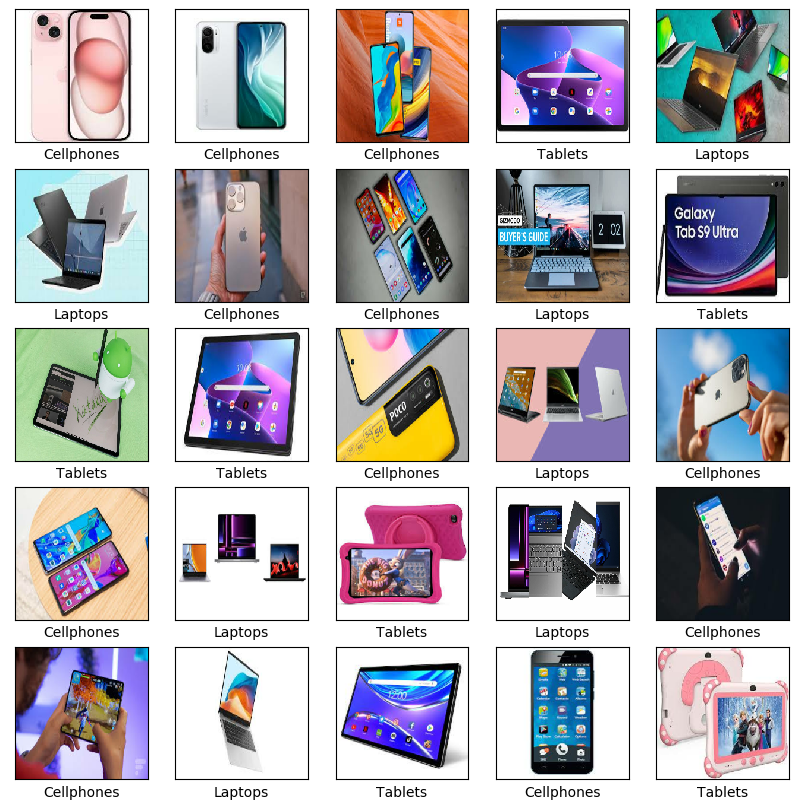

In [3]:
# Prepare your data
# x_train   shape: (300, 224, 224, 3)   range: 0.0  -> 1.0      dtype: float32
# y_train   shape: (300)                range: 0    -> 2        dtype: uint8
# x_test    shape: (60, 224, 224, 3)    range: 0.0  -> 1.0      dtype: float32
# y_test    shape: (60)                 range: 0    -> 2        dtype: uint8

train_images = train_batch[0] / 255
train_labels = train_batch[1].astype(np.uint8)
test_images = test_batch[0] / 255
test_labels = test_batch[1].astype(np.uint8)

def inspect_data(name, array):
    '''Prints the name as well as the dtype, shape and range (min, max and mean value) of the given array.'''
    
    print(name + ":")
    # Add lines here --->
    print("dtype: {}".format(array.dtype))
    print("shape: {}".format(array.shape))
    print("ragne is between {:.0f} and {:.0f} (Ø {:.2f})".format(np.min(array),np.max(array),np.mean(array)))
    # <--- Add lines here
    print()

def inspect_all_data():
    
    inspect_data("train_images", train_images)
    inspect_data("train_labels", train_labels)
    inspect_data("test_images", test_images)
    inspect_data("test_labels", test_labels)
    
inspect_all_data()

class_names = ["Cellphones", "Laptops", "Tablets"]

plt.figure(figsize=(10,10))

for index in range(25):
    plt.subplot(5, 5, index + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[index], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[index]])

#### Augment data

In [4]:
# Augment your data (only here if you are not using real-time data augmentation)

# Add your code here...

### Models

#### MLP model

In [5]:
# Build MLP model
# Max. Dense layers: 8
# Max. Conv2D layers: 0
# Max. params: 150,000,000

max_params = 150_000_000
max_units_dense_layer = max_params // (224 * 224 * 3)

model_mlp = tf.keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(224,224,3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Flatten(input_shape=(224,224,3)),
    layers.Dense(200, activation=tf.keras.activations.relu),
    layers.Dense(200, activation=tf.keras.activations.relu),
    layers.Dense(200, activation=tf.keras.activations.relu),
    layers.Dense(200, activation=tf.keras.activations.relu),
    layers.Dense(200, activation=tf.keras.activations.relu),
    layers.Dense(200, activation=tf.keras.activations.relu),
    layers.Dense(200, activation=tf.keras.activations.relu),
    layers.Dense(3, activation=tf.keras.activations.softmax)
])

# Add your code here...
model_mlp.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 224, 224, 3)       0         
                                                                 
 flatten (Flatten)           (None, 150528)            0         
                                                                 
 dense (Dense)               (None, 200)               30105800  
                                                                 
 dense_1 (Dense)             (None, 200)               40200     
                                                        

#### Small CNN model

In [6]:
# Build small CNN model
# Max. Dense layers: 1
# Max. Conv2D layers: 4
# Max. params: 10,000,000

model_cnn_s = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.Flatten(),
    
    layers.Dropout(0.5),
    layers.Dense(3, activation='softmax')
])


# Print model summary to check the number of parameters
model_cnn_s.summary()

# Add your code here...

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization (BatchN  (None, 222, 222, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 64)    

#### Medium CNN model

In [42]:
# Build medium CNN model
# Max. Dense layers: 2
# Max. Conv2D layers: 10
# Max. params: 30,000,000

model_cnn_m = tf.keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(224, 224, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Conv2D(512, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    layers.Flatten(),
    
    layers.Dense(1024, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dropout(0.5),
    
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    
    layers.Dropout(0.5),
    
    layers.Dense(3, activation='softmax')
])

# Print model summary to check the number of parameters
model_cnn_m.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_3 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_3 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 222, 222, 64)      1792      
                                                                 
 batch_normalization_12 (Bat  (None, 222, 222, 64)     256       
 chNormalization)                                                
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 111, 111, 64)    

#### Large CNN model

In [8]:
# Build large CNN model
# Max. Dense layers: 2
# Max. Conv2D layers: 30
# Max. params: 100,000,000

model_cnn_l = tf.keras.Sequential([
    # Add your code here...
])

# Add your code here...

### Training

In [9]:
# Train your model(s)
from time import time

epochs = 30#hoose your epoch count
batch_size = 10 # Choose your batch size
#model = model_mlp # Choose your model
model= model_cnn_s # Choose your model

model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=["accuracy"])

# Add your code here...
start_time = time()

training = model.fit(train_images,
                     train_labels,
                     validation_data=(test_images, test_labels),
                     epochs=epochs,
                     batch_size=batch_size)

# Add your code here...
print()
print(f"Training finished after {time() - start_time:.3f} s")

Epoch 1/30
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
30/30 [==============================] - ETA: 0s - loss: 3.4907 - accuracy: 0.4367WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x0000016D84E37708> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) 

### Visualization

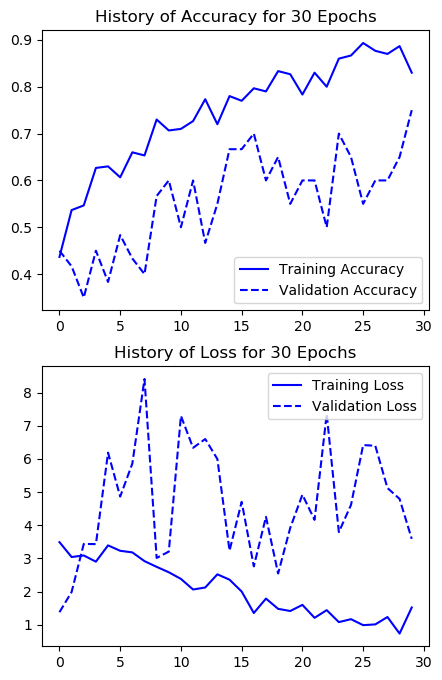

In [40]:
# Add your code here...
acc = training.history['accuracy']
val_acc = training.history['val_accuracy']

loss = training.history['loss']
val_loss = training.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(5, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', linestyle='solid', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', linestyle='dashed', color='blue')
plt.legend(loc='lower right')
plt.title(f'History of Accuracy for {len(epochs_range)} Epochs')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss', linestyle='solid', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', linestyle='dashed', color='blue')
plt.legend(loc='upper right')
plt.title(f'History of Loss for {len(epochs_range)} Epochs')
plt.show()

## Predictions

In [33]:
predictions = model.predict(test_images)

predictions[0]

predicted_label = np.argmax(predictions[0])
predicted_score = predictions[0][predicted_label]

print(f"Predicted label: {predicted_label} with {predicted_score:2.1%} ('{class_names[predicted_label]}')\n")

print(f"This is the {'CORRECT' if test_labels[0] == predicted_label else 'INCORRECT'} label!")


2/2 [==============================] - 0s 231ms/step
Predicted label: 1 with 100.0% ('Laptops')

This is the CORRECT label!


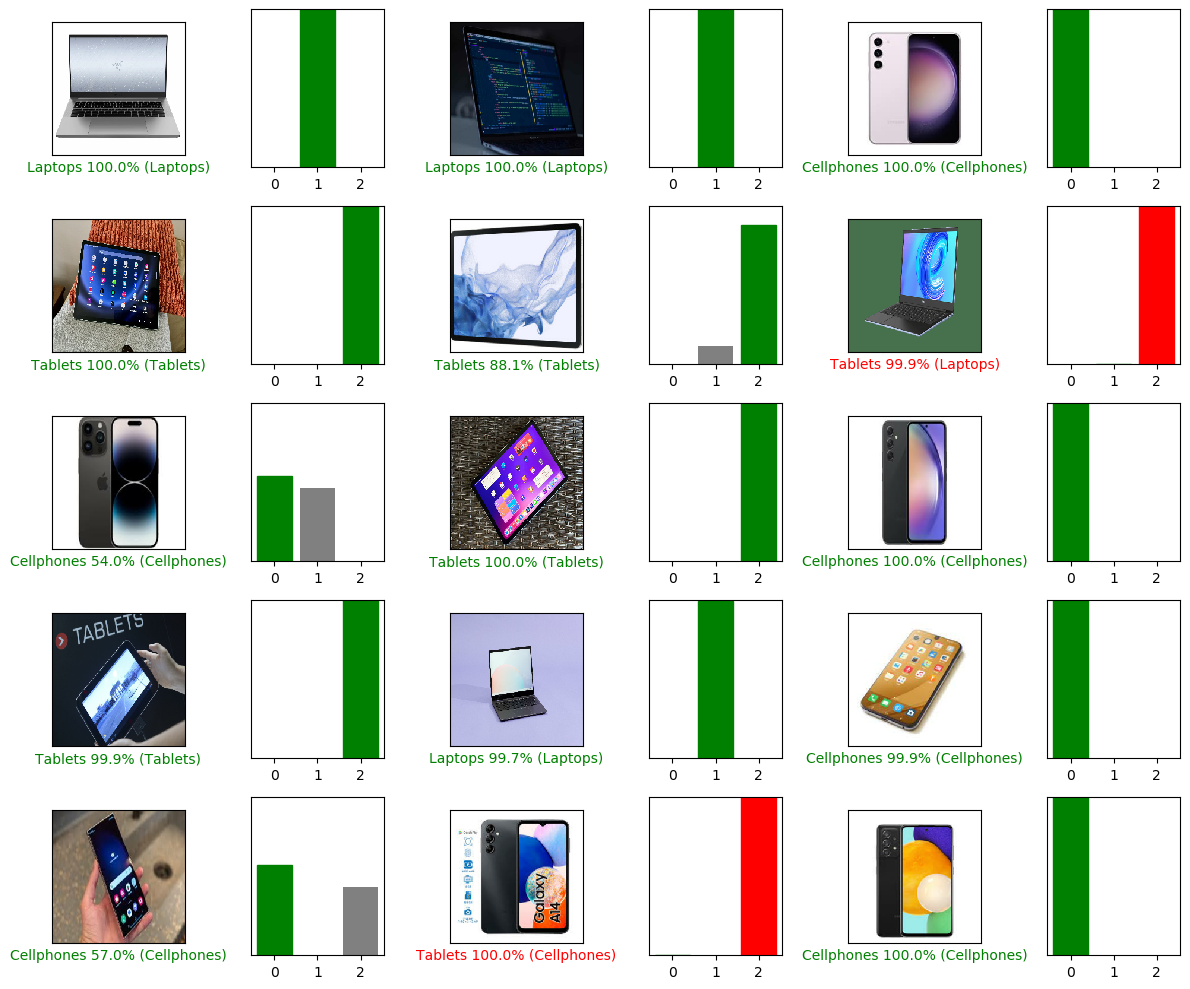

In [32]:
 def plot_image(predictions, groundtruth, image):
    
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(image, cmap=plt.cm.binary)
    
    # Complete lines here --->
    # prediction_index = ...
    predicted_label = np.argmax(predictions)
    # prediction_probability = ...
    prediction_probability = predictions[predicted_label]
    # <--- Complete lines here
    
    if predicted_label == groundtruth:
        color = "green"
    else:
        color = "red"
    
    # Old style string formatting to allow coloring
    plt.xlabel("{} {:2.1%} ({})".format(class_names[predicted_label],
                                        prediction_probability,
                                        class_names[groundtruth]),
                                        color=color)

def plot_value_array(predictions, groundtruth):
    
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    
    thisplot = plt.bar(range(3), predictions, color="gray")
    plt.ylim([0, 1])

    # Complete lines here --->
    predicted_label = np.argmax(predictions)
    # prediction_index = ...

    thisplot[predicted_label].set_color("red")
    thisplot[groundtruth].set_color("green")
    
num_rows = 5
num_cols = 3

def subplot(index, plot_number):
    plt.subplot(num_rows, 2 * num_cols, 2 * index + plot_number)

plt.figure(figsize=(4 * num_cols, 2 * num_rows))

for index in range(num_rows * num_cols):
    subplot(index, 1)
    plot_image(predictions[index], test_labels[index], test_images[index])
    
    subplot(index, 2)
    plot_value_array(predictions[index], test_labels[index])
    
plt.tight_layout()
plt.show()